# DBSCAN model

The numeric dataset which have been chosen is the `glass dataset`. There are 3 main classes we should ditinguish:

- Windows with float treatment (build_wind_float and vehic_wind_float)
- Windows with no float treatment (build_wind_non_float)
- Non windows glass (containers, tableware, headlamps)

In [9]:
from src.read.processing import Processing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

dataclass = Processing(source_path='input/datasets/')
df = dataclass.read('glass')

# Fix problem with K column name
df.columns = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type']

# Set class names from "Type" column
d_class = {'build_wind_float':'float', 'vehic_wind_float':'float',
           'build_wind_non-float':'non_float', 'containers':'non_wind', 
           'tableware':'non_wind', 'headlamps':'non_wind'}

df['Class'] = df['Type'].map(d_class)
d_class_num = {"non_float":0, "float":1, "non_wind":2}
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type,Class
0,1.51793,12.79,3.50,1.12,73.03,0.64,8.77,0.0,0.00,build_wind_float,float
1,1.51643,12.16,3.52,1.35,72.89,0.57,8.53,0.0,0.00,vehic_wind_float,float
2,1.51793,13.21,3.48,1.41,72.64,0.59,8.43,0.0,0.00,build_wind_float,float
3,1.51299,14.40,1.74,1.54,74.55,0.00,7.59,0.0,0.00,tableware,non_wind
4,1.53393,12.30,0.00,1.00,70.16,0.12,16.19,0.0,0.24,build_wind_non-float,non_float


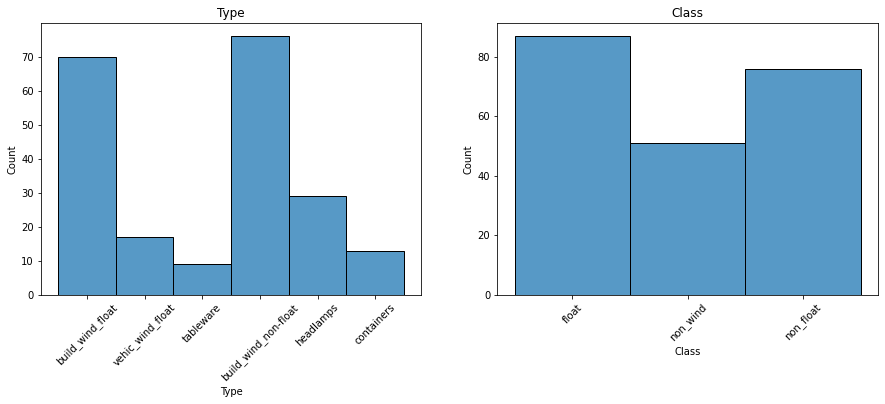

In [2]:
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df, x='Type', ax=ax[0])
sns.histplot(data=df, x='Class', ax=ax[1])
ax[0].set_title('Type')
ax[1].set_title('Class')

# rotate x-axis labels
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

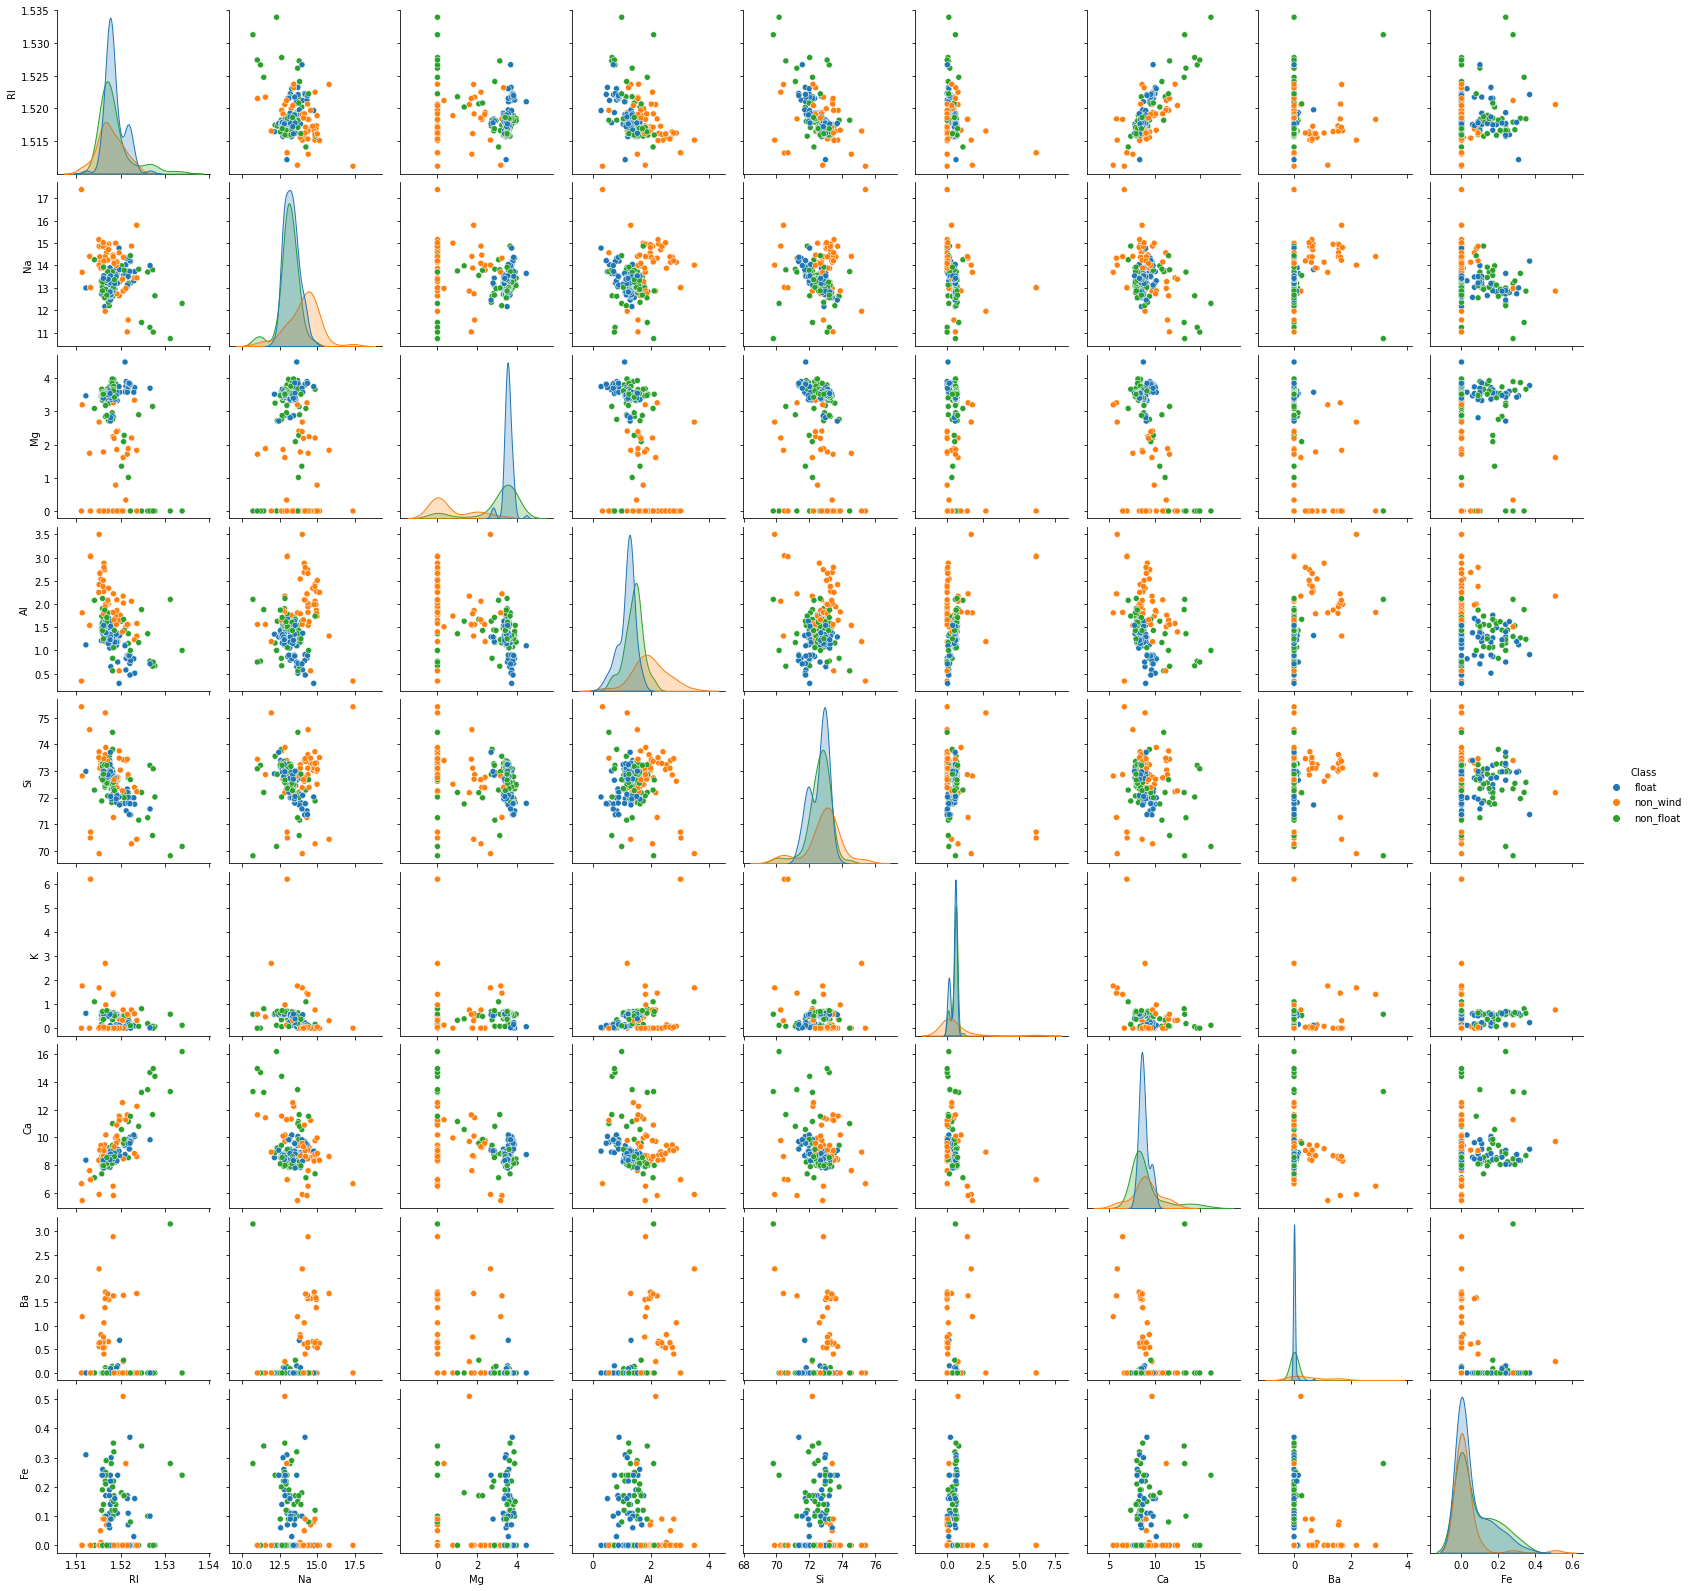

In [3]:
sns.pairplot(df, hue='Class')
plt.savefig('notebooks/dbscan/figs/pairplot.png');

In [4]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000


<AxesSubplot:title={'center':'Variation Coefficient'}>

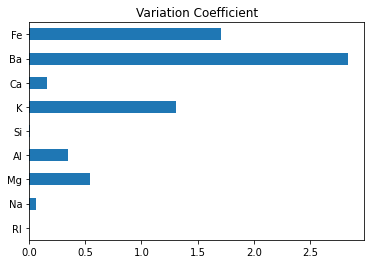

In [5]:
df.select_dtypes(include=float).apply(lambda x: x.std()/x.mean()).plot.barh(title="Variation Coefficient")

In [6]:
df_agg = df.groupby('Class').agg(['mean', 'std'])
df_agg

RI                   Na                  Mg            \
               mean       std       mean       std      mean       std   
Class                                                                    
float      1.518571  0.002214  13.280345  0.503842  3.550690  0.232183   
non_float  1.518619  0.003802  13.111711  0.664159  3.002105  1.215661   
non_wind   1.517638  0.002909  14.066667  1.066836  0.733725  1.101443   

                 Al                   Si                   K            \
               mean       std       mean       std      mean       std   
Class                                                                    
float      1.171149  0.287319  72.577241  0.562442  0.439425  0.217129   
non_float  1.408158  0.318340  72.598026  0.724573  0.521053  0.213726   
non_wind   1.966667  0.598129  72.855490  1.080586  0.559608  1.285207   

                 Ca                  Ba                  Fe            
               mean       std      mean       std      mean       std  
Class                                                                  
float      8.794483  0.540374  0.011954  0.076733  0.057011  0.092361  
non_float  9.073684  1.921635  0.050263  0.362340  0.079737  0.106433  
non_wind   9.060196  1.584069  0.639216  0.745930  0.023137  0.082619

In [34]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, v_measure_score, confusion_matrix, classification_report

cols = ["Fe", "Ba", "K", "Al", "Mg"]
X = df[cols]
y = df['Class'].map(d_class_num).values.reshape(-1, 1)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (214, 5)
y shape: (214, 1)


X_train shape: (171, 5)
X_test shape: (43, 5)


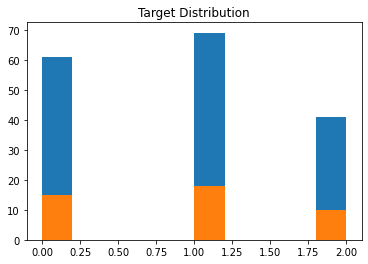

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    test_size=.2,
                                                    stratify=y)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

plt.hist(y_train)
plt.hist(y_test)
plt.title("Target Distribution");

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
    
# dbscan = Pipeline([('scaler', StandardScaler()), 
#                    ('model', DBSCAN())])
# gs = GridSearchCV(dbscan, param_grid={'model__eps':np.arange(0.1, 1.1, 0.1),
#                                       'model__min_samples':np.arange(1, 10)},
#                   scoring='v_measure_score',
#                   cv=3)

# gs.fit(X_train, y_train)

cv = KFold(n_splits=3, shuffle=True, random_state=0)
ls_scores = []
for train_index, val_index in cv.split(X_train):
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
    
    dbscan = Pipeline([('scaler', StandardScaler()), 
                       ('model', DBSCAN(eps=0.4, min_samples=2))])
    dbscan.fit(X_train_cv)
    y_pred = dbscan['model'].labels_.reshape(-1, 1)
    ls_scores.append(silhouette_score(y_train_cv, y_pred))

ls_scores

/home/alberto/anaconda3/envs/iml_project/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alberto/anaconda3/envs/iml_project/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alberto/anaconda3/envs/iml_project/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[-0.6024803540702109, -0.8070175438596491, -0.7894736842105263]

In [38]:
ls_scores

[-0.460077934674278, -0.11113948792137252, -0.13538905402978849]